# Explainable AI Notebook

## Imports

In [6]:
# Set root directory of the project as the current working directory
import os
import sys

module_path = os.path.abspath('..')
if module_path not in sys.path:
    %cd ..




In [7]:
sys.path

['/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python311.zip',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/lib-dynload',
 '',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages',
 '/Users/johannesherstad/miniconda3/envs/D2D_env/lib/python3.11/site-packages/setuptools/_vendor',
 '/Users/johannesherstad']

In [ ]:
# ======================
# Standard Library
# ======================
import logging
import os
import random

# ======================
# Third-Party Libraries
# ======================
import kerastuner as kt
import lime
from lime.lime_tabular import LimeTabularExplainer
import mat4py as mpy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

# ======================
# TensorFlow / Keras
# ======================
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# ======================
# Custom Modules
# ======================
from config.defaults import Config
from src.evaluation import evaluate_regression_model, plot_true_vs_pred
from src.models import load_preprocessed_data, load_saved_model

# ======================
# Configuration
# ======================
logging.getLogger().setLevel(logging.WARNING)
config = Config()



## Data loading

In [9]:
# Load preprocessed data

# Regression
X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, metadata = load_preprocessed_data(model_task = "regression" , eol_capacity=config.eol_capacity)

# Classification
X_train, X_val, X_test, y_train_clf, y_val_clf, y_test_clf, metadata = load_preprocessed_data(model_task = "classification" , eol_capacity=config.eol_capacity)


## Load and Evaluate models

### Regression

#### LSTM

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mae: 0.0282  


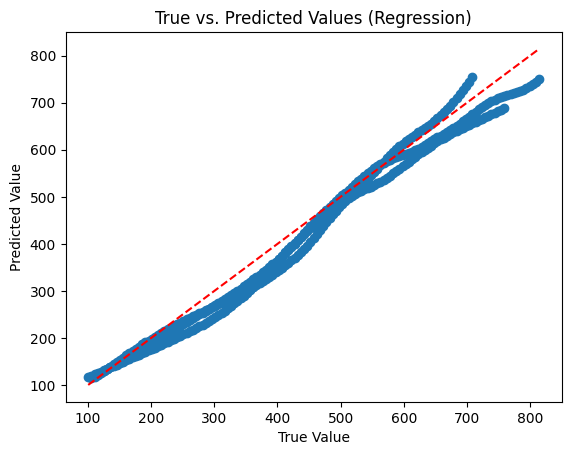

Test MSE: 0.0010621232355951123
Test R2: 0.9710840762774161
Test MAE: 0.026999550462833897


In [10]:
# 1) Load the model
lstm_model = load_saved_model(model_task = "lstm_regression", config=config)

# 2) Generate predictions
y_pred = lstm_model.predict(X_test)

# 3) Evaluate (for example, if your evaluate_regression_model only needs X_test, y_test)
test_loss, mae_rescaled = evaluate_regression_model(
    model=lstm_model, 
    X_test=X_test, 
    y_test=y_test_reg, 
    y_max=metadata["y_max"]
)

# 4) Plot
plot_true_vs_pred(y_test_reg, y_pred, y_max=metadata["y_max"])

mse_test_lstm = mean_squared_error(y_test_reg, y_pred)
r2_test_lstm = r2_score(y_test_reg, y_pred)

print(f"Test MSE: {mse_test_lstm}")
print(f"Test R2: {r2_test_lstm}")

# MAE
mae_test_lstm = mean_absolute_error(y_test_reg, y_pred)
mae_test_lstm_rescaled = mae_test_lstm * metadata["y_max"]
print(f"Test MAE: {mae_test_lstm}")


#### Interpretable Alternative

In [11]:


# Example reshaping assuming X_train has shape (n_samples, timesteps, n_features)
n_samples, timesteps, n_features = X_train.shape

# Reshape data by flattening the time dimension
X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], timesteps * n_features)

# -----------------------------
# Train Decision Tree Regressor
# -----------------------------
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_regressor.fit(X_train_flat, y_train_reg)

# Make predictions on validation and test sets
y_val_pred_dt = dt_regressor.predict(X_val_flat)
y_test_pred_dt = dt_regressor.predict(X_test_flat)

# Evaluate Decision Tree Regressor performance
mse_val_dt = mean_squared_error(y_val_reg, y_val_pred_dt)
r2_val_dt = r2_score(y_val_reg, y_val_pred_dt)
mse_test_dt = mean_squared_error(y_test_reg, y_test_pred_dt)
r2_test_dt = r2_score(y_test_reg, y_test_pred_dt)

print("Decision Tree Regressor:")
print(f"Validation MSE: {mse_val_dt:.4f}, R2: {r2_val_dt:.4f}")
print(f"Test MSE: {mse_test_dt:.4f}, R2: {r2_test_dt:.4f}")

mae_test_dt = mean_absolute_error(y_test_reg, y_test_pred_dt)
mae_test_dt_rescaled = mae_test_dt * metadata["y_max"]
print(f"Test MAE: {mae_test_dt}")

# -----------------------------
# Train Linear Regression Model
# -----------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_reg)

# Make predictions on validation and test sets
y_val_pred_lr = lin_reg.predict(X_val_flat)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Evaluate Linear Regression performance
mse_val_lr = mean_squared_error(y_val_reg, y_val_pred_lr)
r2_val_lr = r2_score(y_val_reg, y_val_pred_lr)
mse_test_lr = mean_squared_error(y_test_reg, y_test_pred_lr)
r2_test_lr = r2_score(y_test_reg, y_test_pred_lr)

print("Linear Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")

mae_test_lr = mean_absolute_error(y_test_reg, y_test_pred_lr)
mae_test_lr_rescaled = mae_test_lr * metadata["y_max"]
print(f"Test MAE: {mae_test_lr}")

Decision Tree Regressor:
Validation MSE: 0.0040, R2: 0.9045
Test MSE: 0.0016, R2: 0.9553
Test MAE: 0.03274400828946735
Linear Regression:
Validation MSE: 0.0051, R2: 0.8794
Test MSE: 0.0029, R2: 0.9214
Test MAE: 0.03925499739535793


Decision Tree Regressor:
Validation MSE: 0.0040, R2: 0.9045
Test MSE: 0.0016, R2: 0.9553



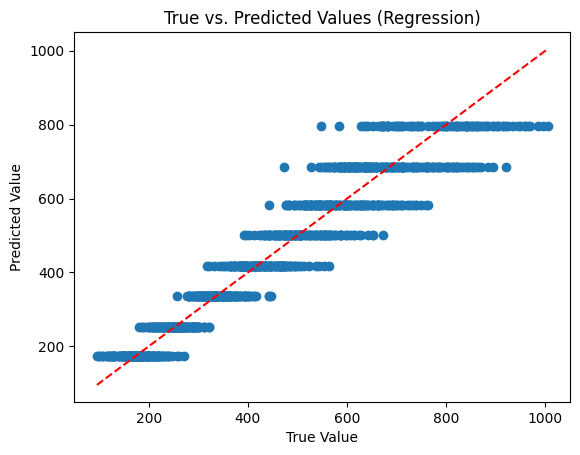

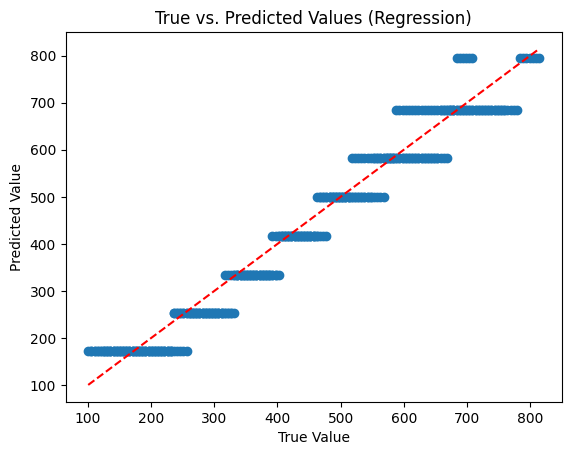

Linear Regression:
Validation MSE: 0.0051, R2: 0.8794
Test MSE: 0.0029, R2: 0.9214


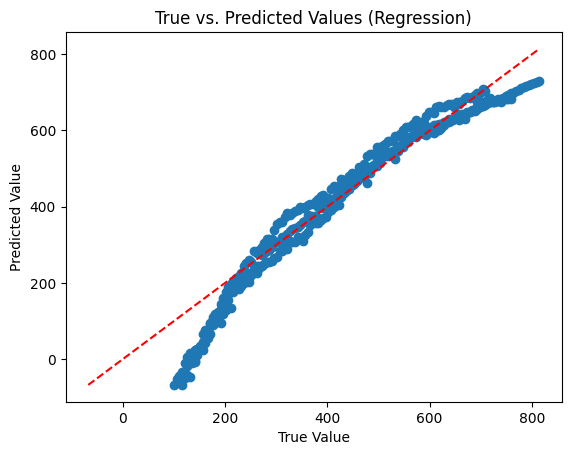

Lasso Regression:
Validation MSE: 0.0051, R2: 0.8794
Test MSE: 0.0029, R2: 0.9214


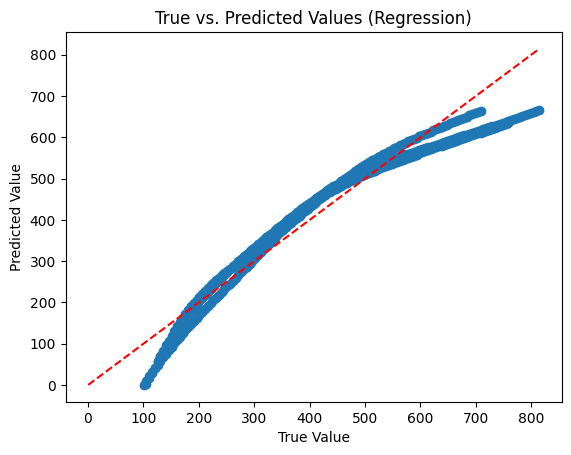

In [12]:
# Assume X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, and metadata are pre-loaded.
# Also assume that the data has shape (n_samples, timesteps, n_features).
# We flatten the time dimension for these models.
n_samples, timesteps, n_features = X_train.shape

X_train_flat = X_train.reshape(n_samples, timesteps * n_features)
X_val_flat = X_val.reshape(X_val.shape[0], timesteps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], timesteps * n_features)

# -----------------------------
# Train Decision Tree Regressor
# -----------------------------
dt_regressor = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_regressor.fit(X_train_flat, y_train_reg)
y_test_pred_dt = dt_regressor.predict(X_test_flat)

# Evaluate using the custom plotting function
print("Decision Tree Regressor:")
print(f"Validation MSE: {mse_val_dt:.4f}, R2: {r2_val_dt:.4f}")
print(f"Test MSE: {mse_test_dt:.4f}, R2: {r2_test_dt:.4f}\n")
plot_true_vs_pred(y_val_reg, y_val_pred_dt, y_max=metadata["y_max"])
plot_true_vs_pred(y_test_reg, y_test_pred_dt, y_max=metadata["y_max"])


# -----------------------------
# Train Linear Regression Model
# -----------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train_flat, y_train_reg)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Evaluate using the custom plotting function
print("Linear Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")
plot_true_vs_pred(y_test_reg, y_test_pred_lr, y_max=metadata["y_max"])

# -----------------------------
# Train Lasso Regression Model
# -----------------------------

from sklearn.linear_model import Lasso
lin_reg = Lasso(alpha=0.005)
lin_reg.fit(X_train_flat, y_train_reg)
y_test_pred_lr = lin_reg.predict(X_test_flat)

# Evaluate using the custom plotting function
print("Lasso Regression:")
print(f"Validation MSE: {mse_val_lr:.4f}, R2: {r2_val_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, R2: {r2_test_lr:.4f}")
plot_true_vs_pred(y_test_reg, y_test_pred_lr, y_max=metadata["y_max"])


Decision Tree Feature Importances:
          Feature  Importance
119  timestep_119     0.98928
114  timestep_114     0.01072
75    timestep_75     0.00000
87    timestep_87     0.00000
86    timestep_86     0.00000
..            ...         ...
35    timestep_35     0.00000
34    timestep_34     0.00000
33    timestep_33     0.00000
32    timestep_32     0.00000
60    timestep_60     0.00000

[120 rows x 2 columns]


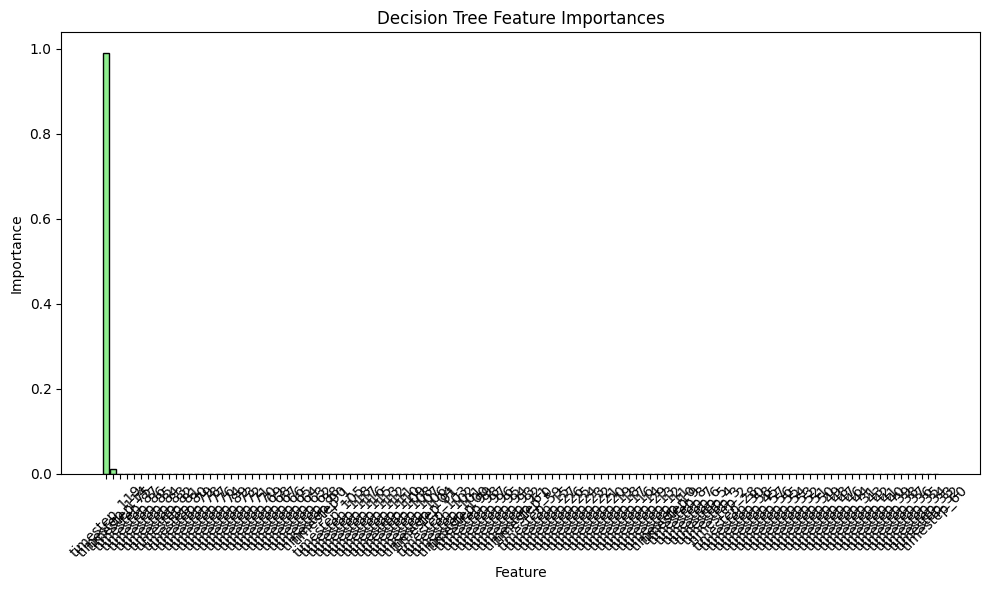

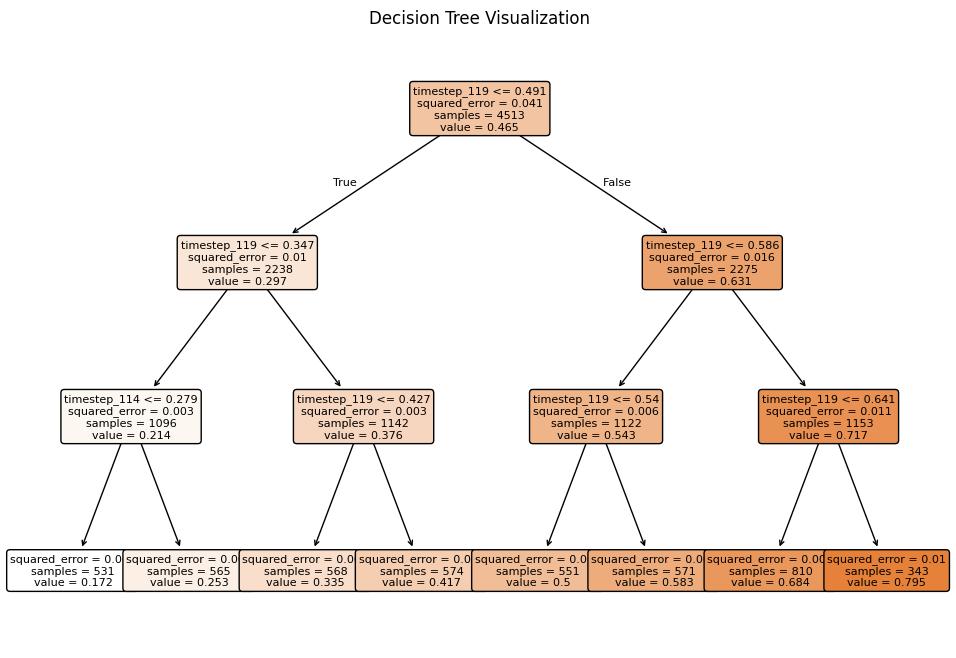

Linear Regression Coefficients:
          Feature  Coefficient
119  timestep_119     1.013609
1      timestep_1     0.000000
88    timestep_88     0.000000
87    timestep_87     0.000000
86    timestep_86     0.000000
..            ...          ...
35    timestep_35     0.000000
34    timestep_34     0.000000
33    timestep_33     0.000000
32    timestep_32     0.000000
60    timestep_60     0.000000

[120 rows x 2 columns]


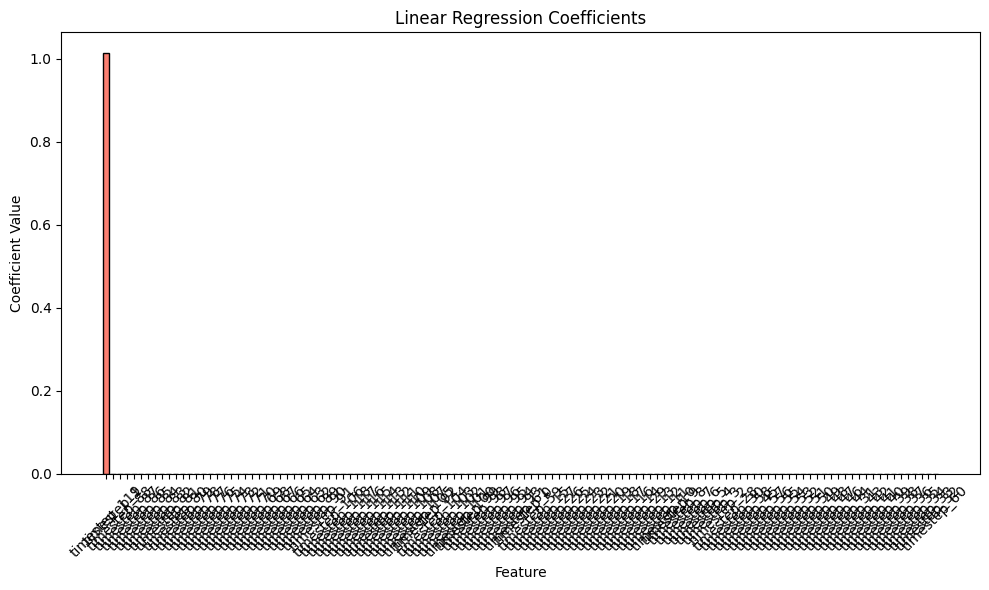

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import plot_tree

# Create a feature name list for each timestep:
feature_names = [f"timestep_{i}" for i in range(120)]

# --------------------------
# 2. Decision Tree Regressor: Feature Importances and Tree Plot
# --------------------------
# Assume:
#   dt_model is your fitted DecisionTreeRegressor.
#   feature_names is a list of feature names corresponding to the columns of your data.

# Print feature importances:
dt_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Decision Tree Feature Importances:")
print(dt_importances)

# Optionally, plot the feature importances as a bar chart:
plt.figure(figsize=(10, 6))
plt.bar(dt_importances['Feature'], dt_importances['Importance'], color='lightgreen', edgecolor='k')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Decision Tree Feature Importances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# You can also visualize the tree (for small trees) using plot_tree:
plt.figure(figsize=(12, 8))
plot_tree(dt_regressor, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

# --------------------------
# 3. Linear Regression: Coefficients
# --------------------------
# Assume:
#   lin_reg is your fitted LinearRegression model.

# Create a DataFrame for the coefficients:
lin_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lin_reg.coef_
}).sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)
print("Linear Regression Coefficients:")
print(lin_coefs)

# Plot the coefficients as a bar chart:
plt.figure(figsize=(10, 6))
plt.bar(lin_coefs['Feature'], lin_coefs['Coefficient'], color='salmon', edgecolor='k')
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


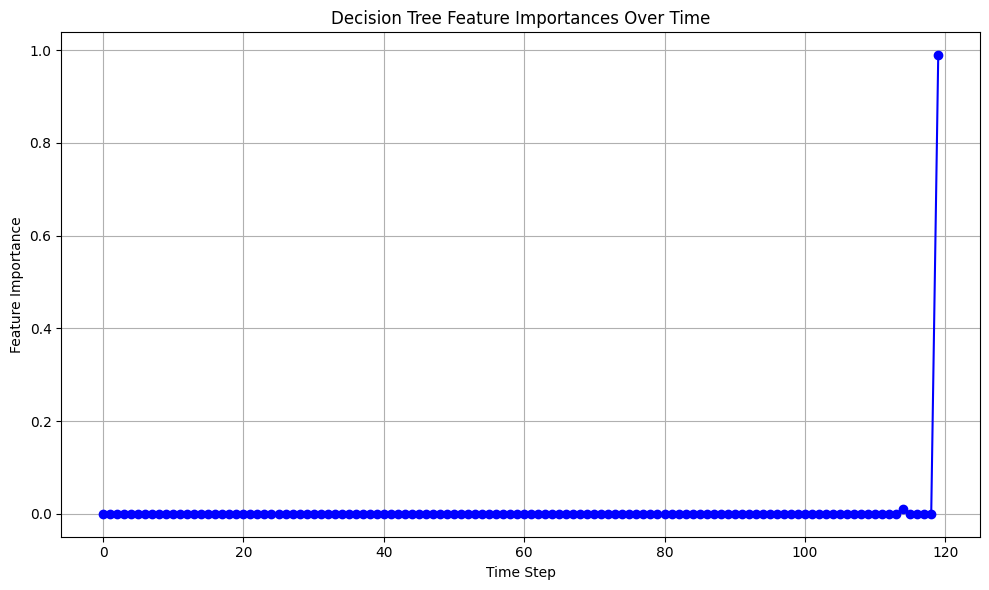

Decision Tree Feature Importances (by timestep):
          Feature  Timestep  Importance
0      timestep_0         0     0.00000
1      timestep_1         1     0.00000
2      timestep_2         2     0.00000
3      timestep_3         3     0.00000
4      timestep_4         4     0.00000
..            ...       ...         ...
115  timestep_115       115     0.00000
116  timestep_116       116     0.00000
117  timestep_117       117     0.00000
118  timestep_118       118     0.00000
119  timestep_119       119     0.98928

[120 rows x 3 columns]


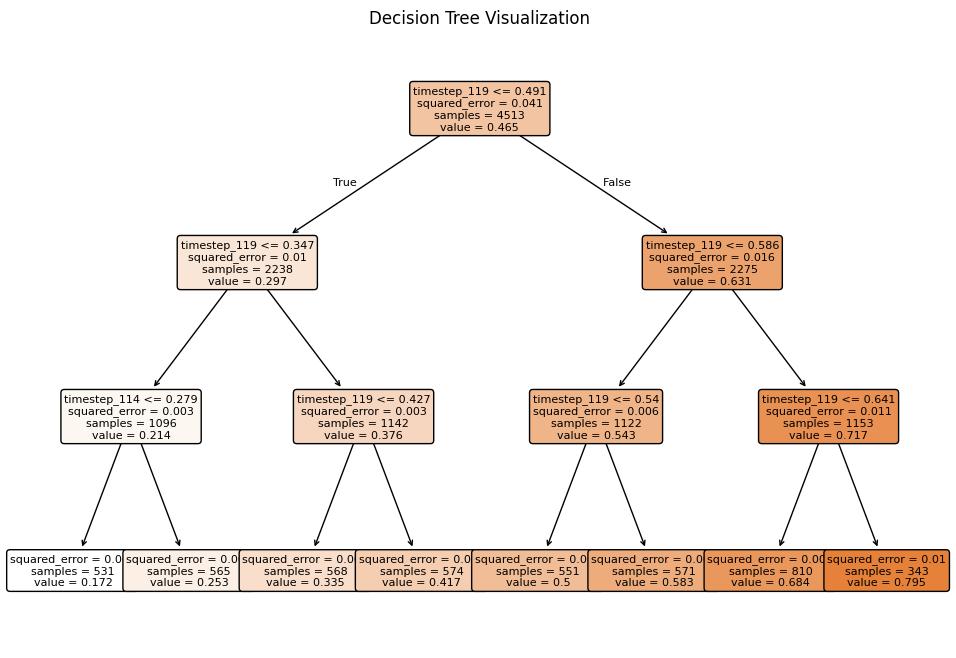

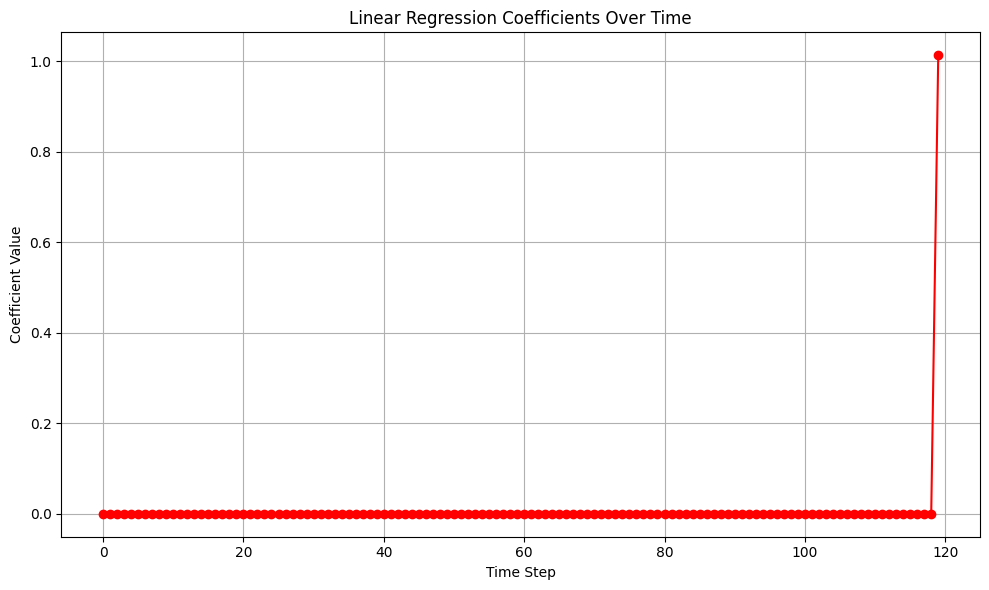

Linear Regression Coefficients (by timestep):
          Feature  Timestep  Coefficient
0      timestep_0         0     0.000000
1      timestep_1         1     0.000000
2      timestep_2         2     0.000000
3      timestep_3         3     0.000000
4      timestep_4         4     0.000000
..            ...       ...          ...
115  timestep_115       115     0.000000
116  timestep_116       116     0.000000
117  timestep_117       117     0.000000
118  timestep_118       118     0.000000
119  timestep_119       119     1.013609

[120 rows x 3 columns]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import plot_tree

# --- Decision Tree Regressor: Continuous Plot of Feature Importances ---
# Assume:
#   dt_regressor is your fitted DecisionTreeRegressor.
#   feature_names is a list of feature names (e.g., ['timestep_0', 'timestep_1', ..., 'timestep_119']).

# Convert feature names to numeric timesteps.
# This example assumes each feature name ends with an underscore followed by the timestep number.
timesteps = np.array([int(f.split('_')[-1]) for f in feature_names])

# Retrieve the feature importances:
importance_values = dt_regressor.feature_importances_

# Create a continuous line plot:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, importance_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Time Step")
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importances Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# You can still print the DataFrame if you want:
dt_importances = pd.DataFrame({
    'Feature': feature_names,
    'Timestep': timesteps,
    'Importance': importance_values
}).sort_values(by='Timestep')
print("Decision Tree Feature Importances (by timestep):")
print(dt_importances)

# Optionally, you may still visualize the tree structure (note: this plot remains a tree view):
plt.figure(figsize=(12, 8))
plot_tree(dt_regressor, feature_names=feature_names, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

# --- Linear Regression: Continuous Plot of Coefficients ---
# Assume:
#   lin_reg is your fitted LinearRegression model.

# Get the coefficients and convert them similarly:
coeff_values = lin_reg.coef_

# Create a continuous line plot:
plt.figure(figsize=(10, 6))
plt.plot(timesteps, coeff_values, marker='o', linestyle='-', color='red')
plt.xlabel("Time Step")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

# Also, print the coefficients in a DataFrame (sorted by timestep):
lin_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Timestep': timesteps,
    'Coefficient': coeff_values
}).sort_values(by='Timestep')
print("Linear Regression Coefficients (by timestep):")
print(lin_coefs)


### Classification

#### 1D Convolutional Neural Network

#### Decision Tree

#### Logistic regression

## Ante-Hoc Explainability Methods

### Regression

#### SHAP

In [21]:
# Reshape the training and test data to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # Shape: (n_train, 120)

# Sample a background dataset and test set. The larger the background dataset, the more accurate the SHAP values.
background = shap.sample(X_train_2d, 100)

# Create a wrapper for the model's predict function
def predict_wrapper(X):
    # Reshape X from (n, 120) to (n, 120, 1)
    return lstm_model.predict(X.reshape(-1, 120, 1))

# Initialize the KernelExplainer with the 2D background data and the wrapper function
explainer_shap = shap.KernelExplainer(predict_wrapper, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [22]:
# Example: Plot the SHAP values for a single test sample

# Compute the SHAP values using the test set
X_test_2d = X_test.reshape(X_test.shape[0], -1)    # Shape: (n_test, 120)
test = shap.sample(X_test_2d, 1)

shap_values = explainer_shap.shap_values(test)

# Assuming shap_values[0] is a (120, 1) array
# Flatten it to a 1D array (120,)
shap_first = shap_values[0].flatten()

# Create the x-axis as timestep indices (0 to 119)
timesteps = np.arange(len(shap_first))

# Create a Plotly scatter plot
fig = go.Figure(data=go.Scatter(x=timesteps, y=shap_first, mode='lines+markers'))
fig.update_layout(
    title="First SHAP Values over Timesteps",
    xaxis_title="Timestep Index",
    yaxis_title="SHAP Value"
)
fig.show()


# Sum up all SHAP values
shap_sum = np.abs(shap_values[0]).sum(axis=0)
print("SHAP sum shape:", shap_sum.shape)
print("SHAP sum:", shap_sum)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


SHAP sum shape: (1,)
SHAP sum: [0.24838306]


In [17]:
print(X_test.shape)

(391, 120, 1)


In [18]:


# ===============================================
# 1) Reshape or Sample Your Test Data for SHAP
# ===============================================
# Suppose X_test originally has shape (n_test, 120, 1)
# We convert it to (n_test, 120) for the explainer
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Sample a subset of test data (e.g., 200 samples) for efficiency
X_test_shap = shap.sample(X_test_2d, 200, random_state=1)

# ===============================================
# 2) Compute SHAP Values for the Sampled Test Set
# ===============================================

# Compute SHAP values for the sampled test set
shap_values = explainer_shap.shap_values(X_test_shap)

# If shap_values is returned as a list (common for single-output models), extract the first element
if isinstance(shap_values, list):
    shap_values = shap_values[0]
# Now, shap_values should have shape: (200, 120)

# ===============================================
# 3) Create a "Global" Explanation
# ===============================================
# A) Compute the mean (signed) SHAP value per timestep across the sampled test set
mean_shap = np.mean(shap_values, axis=0)  # shape: (120,)

# B) Compute the mean absolute SHAP value per timestep across the sampled test set
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)  # shape: (120,)

# ===============================================
# 4) Plot Global SHAP Values with Plotly
# ===============================================
timesteps = np.arange(len(mean_shap))  # [0, 1, ..., 119]

# --- Plot: Mean SHAP Value (signed) ---
fig_mean = go.Figure(data=go.Scatter(
    x=timesteps,
    y=mean_shap,
    mode='lines+markers'
))
fig_mean.update_layout(
    title="Global Explanation: Mean SHAP Values by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Mean SHAP Value"
)
fig_mean.show()

# --- Plot: Mean Absolute SHAP Value ---
fig_abs = go.Figure(data=go.Scatter(
    x=timesteps,
    y=mean_abs_shap,
    mode='lines+markers'
))
fig_abs.update_layout(
    title="Global Explanation: Mean Absolute SHAP Values by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Mean Absolute SHAP Value"
)
fig_abs.show()

print("Max Timestep by Mean SHAP:", np.argmax(mean_shap))
print("Max Timestep by Mean Abs SHAP:", np.argmax(mean_abs_shap))


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
1/1 ━━━━━━━━━━━━

KeyboardInterrupt: 

#### LIME

In [31]:
# X_train and X_test have shape (n_samples, 120, 1)
# Reshape to 2D: each sample becomes a 1D vector with 120 timesteps.
X_train_2d = X_train.reshape(X_train.shape[0], -1)  # (n_train, 120)

# Create a feature name list for each timestep:
feature_names = [f"timestep_{i}" for i in range(120)]

# Define a prediction wrapper that converts a 2D input to the model's expected 3D shape.
def predict_wrapper_lime(X):
    # X is a 2D array of shape (n, 120); reshape to (n, 120, 1) for the LSTM model.
    return lstm_model.predict(X.reshape(-1, 120, 1))

# Initialize the LIME explainer for regression.
explainer_lime = LimeTabularExplainer(
    training_data=X_train_2d,
    feature_names=feature_names,
    mode='regression',
    discretize_continuous=True #For tabular data this is recommended to be True, however as this is time series data where each feature is a timestep and therefore are all in the same range, we set it to False
)

In [32]:
# Example: Explain a single instance from the test set

X_test_2d = X_test.reshape(X_test.shape[0], -1)     # (n_test, 120)
instance = X_test_2d[0]  # A 1D vector of shape (120,)

# Generate a LIME explanation for the selected instance.
# 'num_features' controls how many timesteps (features) will be shown in the explanation.
explanation = explainer_lime.explain_instance(instance, predict_wrapper_lime, num_features=120)

# Get the LIME explanation as a list of tuples:
lime_explanation_list = explanation.as_list()  # e.g., [("timestep_0", 0.12), ("timestep_1", -0.05), ...]

# Convert to DataFrame:
df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

# Extract numeric timestep index from the feature names, assuming they follow "timestep_<number>"
df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)

# Now create a Plotly bar plot using the numeric x-axis.
fig = go.Figure(data=go.Bar(
    x=df_lime["timestep_index"],
    y=df_lime["contribution"],
    marker_color="teal"
))
fig.update_layout(
    title="LIME Explanation by Timestep",
    xaxis_title="Timestep Index",
    yaxis_title="Contribution",
    xaxis=dict(tickmode="linear", dtick=10)  # dtick=10 will show ticks every 10 timesteps
)
fig.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


#### Comparing Ante-Hoc Explainability Methods for Regression

In [35]:
# ===============================================
# Looking at how SHAP and LIME values compare for samples for different values of the target variable
# ===============================================
# The purpose of this section is to show how the predictions change for samples with different target values.
# We will pick samples at different percentiles of the target variable, then compare SHAP and LIME explanations.


y_pred_lstm = lstm_model.predict(X_test_2d.reshape(-1, 120, 1)).flatten()

# =======================================
# 1) Single Model Prediction Wrapper
# =======================================
def predict_wrapper(X):
    """
    X: 2D array of shape (n_samples, 120).
    Returns: (n_samples,) predictions.
    """
    return lstm_model.predict(X.reshape(-1, 120, 1)).flatten()

# =======================================
# 2) Pick Interesting Samples (Percentiles)
# =======================================
sorted_indices = np.argsort(y_test_reg)  # or np.argsort(y_test_flat), your choicea
n_samples = len(y_test_reg)

p0_index   = sorted_indices[0]
p25_index  = sorted_indices[int(0.25 * n_samples)]
p50_index  = sorted_indices[int(0.50 * n_samples)]
p75_index  = sorted_indices[int(0.75 * n_samples)]
p100_index = sorted_indices[-1]

percentile_indices = {
    "p0 (Lowest)": p0_index,
    "p25": p25_index,
    "p50": p50_index,
    "p75": p75_index,
    "p100 (Highest)": p100_index
}

print("Percentile sample indices based on true values:")
for label, idx in percentile_indices.items():
    print(f"{label}: index {idx}, "
          f"prediction {y_test_reg[idx]:.4f}, "
          f"true {y_pred_lstm[idx]:.4f}")

# =======================================
# 3) Combined SHAP + LIME Plot Function
# =======================================
def explain_and_plot_shap_lime(sample_2d, sample_index, label, y_true, y_pred):
    """
    Compute SHAP + LIME values for a single sample, then make
    one grouped bar chart (SHAP vs. LIME) across timesteps.
    """

    # ~~~~~ SHAP Explanation ~~~~~
    sample_2d_reshaped = sample_2d.reshape(1, -1)
    shap_values_single = explainer_shap.shap_values(sample_2d_reshaped)
    shap_values_single = shap_values_single[0].flatten()  # shape (120,)

    df_shap = pd.DataFrame({
        "timestep_index": np.arange(len(shap_values_single)),
        "shap_value": shap_values_single
    })

    # ~~~~~ LIME Explanation ~~~~~
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper,     # Use the same wrapper
        num_features=120
    )
    lime_explanation_list = lime_explanation.as_list()  # [(feature_name, contribution), ...]
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])

    # If features are named like "timestep_0", extract the numeric index:
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    df_lime = df_lime.sort_values("timestep_index")

    # ~~~~~ Merge Both into One DataFrame ~~~~~
    df_combined = pd.merge(
        df_shap, 
        df_lime[["timestep_index", "contribution"]], 
        on="timestep_index",
        how="inner"
    ).rename(columns={"shap_value": "shap_value", "contribution": "lime_contribution"})
    # Now we have: [timestep_index, shap_value, lime_contribution]

    # ~~~~~ Plotly Grouped Bar Chart ~~~~~
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df_combined["timestep_index"],
        y=df_combined["shap_value"],
        name="SHAP Value"
    ))
    fig.add_trace(go.Bar(
        x=df_combined["timestep_index"],
        y=df_combined["lime_contribution"],
        name="LIME Contribution"
    ))
    fig.update_layout(
        barmode='group',
        title=f"SHAP + LIME (Sample #{sample_index})<br>"
              f"Label: {label} | True: {y_true:.4f} | Pred: {y_pred:.4f}",
        xaxis_title="Timestep Index",
        yaxis_title="Value",
        xaxis=dict(tickmode="linear", dtick=10)
    )
    fig.show()

# =======================================
# 4) Generate Combined Plots
# =======================================
for label, idx in percentile_indices.items():
    sample_2d = X_test_2d[idx]  # shape: (120,)
    true_val  = y_test_reg[idx]
    pred_val  = y_pred_lstm[idx]
    
    explain_and_plot_shap_lime(
        sample_2d=sample_2d,
        sample_index=idx,
        label=label,
        y_true=true_val,
        y_pred=pred_val
    )


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Percentile sample indices based on true values:
p0 (Lowest): index 273, prediction 0.1005, true 0.1168
p25: index 239, prediction 0.2714, true 0.2214
p50: index 75, prediction 0.4372, true 0.4149
p75: index 174, prediction 0.5980, true 0.5649
p100 (Highest): index 0, prediction 0.8141, true 0.7510


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [36]:


# --------------------------
# Function: Compute Top-K Overlap
# --------------------------
def compute_top_k_overlap(sample_2d, k=10):
    """
    For a given sample (a 1D array of length 120), compute:
      - Top-k features (timesteps) from SHAP (based on absolute SHAP values)
      - Top-k features (timesteps) from LIME (based on absolute contribution)
      - The overlap between these two sets.
      
    Returns:
      top_k_shap: Sorted list (ascending) of top-k timestep indices from SHAP.
      top_k_lime: Sorted list (descending by absolute value) of top-k timestep indices from LIME.
      overlap: Number of overlapping features.
      overlap_ratio: Overlap divided by k.
    """
    # ---- SHAP Explanation ----
    sample_reshaped = sample_2d.reshape(1, -1)
    shap_values_sample = explainer_shap.shap_values(sample_reshaped)
    # If returned as list, extract first element for single-output model:
    if isinstance(shap_values_sample, list):
        shap_values_sample = shap_values_sample[0]
    # Flatten to 1D array of shape (120,)
    shap_values_sample = shap_values_sample.flatten()
    
    # Get top-k indices for SHAP (largest absolute values)
    top_k_shap = np.argsort(np.abs(shap_values_sample))[-k:]
    
    # ---- LIME Explanation ----
    lime_explanation = explainer_lime.explain_instance(
        sample_2d,
        predict_wrapper,     # same wrapper used for SHAP
        num_features=120
    )
    lime_explanation_list = lime_explanation.as_list()  # list of (feature, contribution)
    df_lime = pd.DataFrame(lime_explanation_list, columns=["feature", "contribution"])
    
    # Extract numeric timestep index from feature names (assuming "timestep_N")
    df_lime["timestep_index"] = df_lime["feature"].str.extract("timestep_(\d+)").astype(int)
    # Compute absolute contribution for sorting
    df_lime["abs_contribution"] = df_lime["contribution"].abs()
    # Get top-k indices for LIME (largest absolute contribution)
    top_k_lime = df_lime.sort_values("abs_contribution", ascending=False).head(k)["timestep_index"].values
    
    # ---- Compute Overlap ----
    overlap = len(set(top_k_shap).intersection(set(top_k_lime)))
    overlap_ratio = overlap / k
    
    return top_k_shap, top_k_lime, overlap, overlap_ratio

# --------------------------
# Example: Top-K Analysis on Percentile Samples
# --------------------------
# Assume y_pred_lstm (or y_test_reg) and percentile_indices are already computed.
# Here we use the percentile_indices from your previous code.
# For example, suppose:
# percentile_indices = {
#     "p0 (Lowest)": p0_index,
#     "p25": p25_index,
#     "p50": p50_index,
#     "p75": p75_index,
#     "p100 (Highest)": p100_index
# }

k = 10  # Change k to how many top features you want to compare

print("Top-K Analysis (k = {}):".format(k))
for label, idx in percentile_indices.items():
    sample_2d = X_test_2d[idx]  # sample of shape (120,)
    top_k_shap, top_k_lime, overlap, overlap_ratio = compute_top_k_overlap(sample_2d, k)
    
    print(f"\nSample Label: {label} (Index {idx})")
    print(f"  Top-{k} SHAP timesteps: {np.sort(top_k_shap)}")
    print(f"  Top-{k} LIME timesteps: {np.sort(top_k_lime)}")
    print(f"  Overlap: {overlap} / {k} (Overlap Ratio: {overlap_ratio:.2f})")


Top-K Analysis (k = 10):


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Sample Label: p0 (Lowest) (Index 273)
  Top-10 SHAP timesteps: [105 107 108 109 110 111 116 117 118 119]
  Top-10 LIME timesteps: [107 108 109 110 111 115 116 117 118 119]
  Overlap: 9 / 10 (Overlap Ratio: 0.90)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Sample Label: p25 (Index 239)
  Top-10 SHAP timesteps: [106 107 108 109 110 111 116 117 118 119]
  Top-10 LIME timesteps: [107 108 109 110 111 115 116 117 118 119]
  Overlap: 9 / 10 (Overlap Ratio: 0.90)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Sample Label: p50 (Index 75)
  Top-10 SHAP timesteps: [106 107 108 109 110 111 115 116 117 118]
  Top-10 LIME timesteps: [  4  39  45 106 108 110 111 117 118 119]
  Overlap: 6 / 10 (Overlap Ratio: 0.60)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Sample Label: p75 (Index 174)
  Top-10 SHAP timesteps: [106 107 108 109 110 111 116 117 118 119]
  Top-10 LIME timesteps: [ 14  16 108 109 110 111 116 117 118 119]
  Overlap: 8 / 10 (Overlap Ratio: 0.80)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
7150/7150 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Sample Label: p100 (Highest) (Index 0)
  Top-10 SHAP timesteps: [106 107 108 109 110 111 116 117 118 119]
  Top-10 LIME timesteps: [107 108 109 110 111 112 116 117 118 119]
  Overlap: 9 / 10 (Overlap Ratio: 0.90)


### Classification

### SHAP

#### Regression

In [ ]:
# Revert shap to 0.39

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Remove the singleton dimension so that shap_values becomes (n_samples, 120)
shap_vals_2d = np.squeeze(shap_values, axis=2)  # shape: (n_samples, 120)

# Compute the global explanation as the mean across samples
global_mean_shap = np.mean(shap_vals_2d, axis=0)  # shape: (120,)

# Compute the global explanation based on the absolute values
global_abs_mean_shap = np.mean(np.abs(shap_vals_2d), axis=0)  # shape: (120,)

# Create an array of timestep indices (0 to 119)
timesteps = np.arange(len(global_mean_shap))

# Plot 1: Mean SHAP Values per timestep
fig_mean = go.Figure(
    data=go.Scatter(x=timesteps, y=global_mean_shap, mode='lines+markers')
)
fig_mean.update_layout(
    title="Global Explanation: Mean SHAP Values by Timestep",
    xaxis_title="Timestep",
    yaxis_title="Mean SHAP Value"
)

# Plot 2: Mean Absolute SHAP Values per timestep
fig_abs_mean = go.Figure(
    data=go.Scatter(x=timesteps, y=global_abs_mean_shap, mode='lines+markers')
)
fig_abs_mean.update_layout(
    title="Global Explanation: Mean Absolute SHAP Values by Timestep",
    xaxis_title="Timestep",
    yaxis_title="Mean Absolute SHAP Value"
)

fig_mean.show()
fig_abs_mean.show()


#### Classification

### TimeSHAP

In [ ]:
"""


from src.TimeSHAP import (
    avg_rul,  get_sequence,
    local_event_explainer, plot_local_event_explanation,
    compute_global_explanation, plot_event_explanation,
)"""

#### Regression

In [ ]:
"""TimeSHAP_n_samples = 1000

f = lambda x: lstm_model.predict(x)

X_train.shape

prun_dict = {'tol': 0.05}

# Select a random test sequence
seq_idx = np.random.randint(0, len(X_test))

seq_idx"""

210

In [ ]:
"""# 1) Compute the baseline sequence
data_2d = X_train.squeeze(axis=-1)            # (n_samples, 120)
mean_per_timestep = np.mean(data_2d, axis=0)  # (120,)
baseline_sequence = mean_per_timestep.reshape(120, 1)

# 2) Get a single test sequence (1, 120, 1)
test_sequence = get_sequence(X_test, 1)

# 3) Reshape baseline to match
baseline_sequence = baseline_sequence.reshape(1, 120, 1)

# 4) Compute local event explanation
event_explanation = local_event_explainer(
    f, 
    test_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

# Plot the event explanation.
plot_local_event_explanation(event_explanation)
"""

Selected index: 1
Sequence shape: (1, 120, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
"""

# 1) Copy the original sequence
modified_sequence = test_sequence.copy()

# 2) Apply a nonlinear decay multiplier from timestep 100 onward.
# The multiplier will start at 1.0 at timestep 100 and drop to 0.9 at the last timestep,
# but with an exponent greater than 1 so the drop is minimal initially and then accelerates.
seq_length = test_sequence.shape[1]  # total timesteps, e.g., 120
if seq_length > 100:
    T = seq_length - 100               # number of timesteps to modify
    p = 2                              # exponent > 1 for accelerating decay later
    indices = np.arange(T)             # indices 0, 1, ..., T-1
    # Compute multipliers: at index 0, multiplier = 1.0; at index T-1, multiplier = 0.9.
    multipliers = 1 - 0.1 * (indices / (T - 1))**p
    modified_sequence[0, 100:, 0] *= multipliers

# 3) Compare predictions
original_pred = f(test_sequence)       # Prediction from original sequence
modified_pred = f(modified_sequence)   # Prediction from modified sequence

print("Original prediction:", original_pred)
print("Modified prediction:", modified_pred)

# 4) Run local explanations for both sequences
original_explanation = local_event_explainer(
    f, 
    test_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

modified_explanation = local_event_explainer(
    f, 
    modified_sequence,
    baseline_sequence,
    pruned_idx=0,
    nsamples=10000
)

# 5) Plot the local event explanations for comparison
fig_original = plot_local_event_explanation(original_explanation)
fig_original.show()

fig_modified = plot_local_event_explanation(modified_explanation)
fig_modified.show()
"""

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Original prediction: [[0.757096]]
Modified prediction: [[0.29167148]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
"""
# X_test_lstm has shape (n_samples, 120, 1)
# average_event is also length 120 (shape (120,1)) from earlier

# 1) We do NOT need to filter out zero-padding or check for >=100 non-zero steps

# 2) We do NOT trim anything, because each sequence is already 120 timesteps

# final_sequences has the same shape as X_test_lstm
final_sequences = X_test

# 3) The baseline is just your average_event, reshaped if needed
baseline_event = baseline_sequence.reshape(1, 120, 1)  # shape (1,120,1)

# 4) Call compute_event_explanation on all sequences
global_explanation = compute_global_explanation(
    f,
    final_sequences,
    baseline=baseline_event,
    random_seed=42,  # or whatever random state
    nsamples=2000,
    verbose=False,
    absolute=False
)

print(global_explanation.shape)  # check the resulting DataFrame

"""


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
63/6

In [ ]:
global_event_chart = plot_event_explanation(global_explanation, relative=False)
global_event_chart.show()

# Take the absolute value of the event_data_bin DataFrame
global_explanation_abs = global_explanation.abs()

global_event_chart_abs = plot_event_explanation(global_explanation_abs, relative=False)
global_event_chart_abs.show()

#### Classification

### Grad-CAM

#### Regression

#### Classification

## Quantitative XAI Evaluation

In this section, we will evaluate the performance of the different XAI methods on the regression and classification tasks.

We will use the following metrics:
* Faithfulness
    * PGI (Prediction-Guided Importance)
    * PGU (Prediction-Guided Unimportance)
*
    


### Faithfulness

Faithfulness is the degree to which the explanation is faithful to the model. It is measured by the correlation between the explanation and the model's prediction.

Through the metrics PGI (Prediction-Guided Importance) and PGU (Prediction-Guided Unimportance), we can measure the faithfulness of the explanation, by perturbing the timesteps deemed most and least important by the XAI methods, and measuring the change in the prediction.

The intuition is that if the XAI method is faithful, perturbing the timesteps deemed most important should have a greater impact on the prediction than perturbing the timesteps deemed least important.

In [ ]:
# Identify the most important timesteps from the results of the Explainable AI techniques.
# The result for each technique is a sorted list, containing the indices of the most important timesteps from least to most important.

# LSTM SHAP

# LSTM TimeSHAP

# 1D-CNN SHAP

# 1D-CNN TimeSHAP

# 1D-CNN GradCAM

In [ ]:
# Perturbation function

def perturbation_function(x, feature_importance_indices):
    # Recieve a list of indices of either the most or the least important timesteps
    # Perturb the values of these timesteps by adding noise to them
    # Return the perturbed input

    x_perturbed = x.copy()
    for idx in feature_importance_indices:
        noise = np.random.normal(loc=0, scale=0.5)
        x_perturbed[idx] = x_perturbed[idx] + noise
    return x_perturbed


In [ ]:
# PGI AND PGU calculation function

def compute_pgi_pgu(model, x, importance_scores, K, runs=10):
    # Compute the PGI and PGU scores for the input x
    # K is the number of timesteps to perturb
    # Runs is the number of times to run the perturbation, to get a more stable estimate
    # Return the PGI and PGU scores

    pgi_scores = []
    pgu_scores = []
    pg_random_scores = []

    # Get the indices of the most important timesteps

    K_most_important = importance_scores[:K]
    print(f"K_most_important: {K_most_important}")
    K_least_important = importance_scores[-K:]
    print(f"K_least_important: {K_least_important}")

    print(x.shape)


    for i in range(runs):
        # Perturb the input for the most important timesteps
        x_perturbed_PGI = perturbation_function(x, K_most_important)

        #print(x_perturbed_PGI)

        # Perturb the input for the least important timesteps
        x_perturbed_PGU = perturbation_function(x, K_least_important)

        # Perturb the input for random timesteps
        random_indices = random.sample(range(120), K)
        x_perturbed_random = perturbation_function(x, random_indices)

        

        # Get the prediction for the original input
        original_prediction = model.predict(x)

        # Get the prediction for the perturbed input for the most important timesteps
        prediction_PGI = model.predict(x_perturbed_PGI)

        # Get the prediction for the perturbed input for the least important timesteps
        prediction_PGU = model.predict(x_perturbed_PGU)

        # Get the prediction for the perturbed input for random timesteps
        prediction_random = model.predict(x_perturbed_random)

        print(f"Original prediction: {original_prediction}")
        print(f"Prediction PGI: {prediction_PGI}")
        print(f"Prediction PGU: {prediction_PGU}")
        print(f"Prediction Random: {prediction_random}")

        # Compute the PGI and PGU scores
        pgi = np.linalg.norm(original_prediction - prediction_PGI)
        pgu = np.linalg.norm(original_prediction - prediction_PGU)
        pg_random = np.linalg.norm(original_prediction - prediction_random)

        pgi_scores.append(pgi)
        pgu_scores.append(pgu)
        pg_random_scores.append(pg_random)

        print(f"Run {i+1}: PGI = {pgi}, PGU = {pgu}, PG_Random = {pg_random}")

    return np.mean(pgi_scores), np.mean(pgu_scores), np.mean(pg_random_scores)


In [ ]:
global_explanation

,Event Number,Average Shapley Value
0,0,0.003294
1,1,-0.000103
2,2,0.001625
3,3,0.001263
4,4,0.002689
...,...,...
115,115,0.030664
116,116,0.043286
117,117,0.051281
118,118,0.043936


In [ ]:
# Sort the global_explanation DataFrame by the values of the importance scores (Average Shapley values)

global_explanation_sorted = global_explanation.sort_values(by="Average Shapley Value", ascending=False)
global_explanation_sorted["Event Number"]



117    117
118    118
116    116
98      98
115    115
      ... 
111    111
108    108
107    107
110    110
109    109
Name: Event Number, Length: 120, dtype: int64

In [ ]:
pgi_scores, pgu_scores, pg_random_scores = compute_pgi_pgu(lstm_model, X_test, global_explanation_sorted["Event Number"]
, K=1, runs=20)

K_most_important: 117    117
Name: Event Number, dtype: int64
K_least_important: 109    109
Name: Event Number, dtype: int64
(391, 120, 1)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Original prediction: [[0.761665  ]
 [0.75709605]
 [0.75353813]
 [0.7509062 ]
 [0.74907184]
 [0.74786675]
 [0.7470944 ]
 [0.7465417 ]
 [0.7459915 ]
 [0.7452352 ]
 [0.7440812 ]
 [0.7423668 ]
 [0.7399628 ]
 [0.7367821 ]
 [0.7327851 ]
 [0.7279836 ]
 [0.7224417 ]
 [0.71627605]
 [0.70964557]
 [0.7027413 ]
 [0.69577396]
 [0.688953  ]
 [0.6824738 ]
 [0.6764974 ]
 [0.67114204]
 [0.66646653]
 [0.6624712 ]
 [0.6590963 ]
 [0.6562246 ]
 [0.6536946 ]
 [0.6513147 ]
 [0.6488795 ]
 [0.64618814]
 [0.6430625 ]
 [0.6393767 ]
 [0.6351311 ]
 [0.6304274 ]
 [0.6254265 ]
 [0.62031657]
 [0.6152848 ]
 [0.61049706]
 [0.6060786 ]
 [0.60210884]
 [0.5986089 ]
 [0.59554815]
 [0.59284604]
 [0.5903828 ]
 [0.5880117 ]
 [0.58557165

In [ ]:
print(pgi_scores, pgu_scores, pg_random_scores)

0.20956175 0.32614148 0.35630476


In [ ]:
import numpy as np
import random

def compute_individual_timestep_impact(model, x, noise_scale=0.5, runs=10):
    """
    Computes the average impact of perturbing each individual timestep in isolation.
    
    Parameters
    ----------
    model : keras.Model or similar
        The model with a predict() function.
    x : np.ndarray
        The input instance with shape (n, T, 1). (We assume n==1 for a single instance.)
    noise_scale : float, optional
        Standard deviation for the Gaussian noise.
    runs : int, optional
        Number of times to run each perturbation for stability.
        
    Returns
    -------
    impacts : dict
        Dictionary mapping each timestep index to the average impact (norm difference)
        in the model's prediction when that timestep is perturbed.
    """
    # Store the baseline prediction
    original_prediction = model.predict(x)
    
    # Number of timesteps (assumes x has shape (1, T, 1))
    T = x.shape[1]
    
    impacts = {}
    for idx in range(T):
        impact_list = []
        for _ in range(runs):
            # Copy the input so we don't modify the original
            x_perturbed = x.copy()
            # Perturb only the current timestep:
            noise = np.random.normal(loc=0, scale=noise_scale)
            x_perturbed[0, idx, 0] += noise
            
            # Compute prediction for perturbed input
            perturbed_prediction = model.predict(x_perturbed)
            # Compute the impact as the norm of the difference
            impact = np.linalg.norm(original_prediction - perturbed_prediction)
            impact_list.append(impact)
        impacts[idx] = np.mean(impact_list)
    return impacts

# Example usage:
# Let's assume you have a single test instance `x_instance` of shape (1, T, 1)
# For example, x_instance = test_sequence, where test_sequence.shape == (1, 120, 1)
impact_dict = compute_individual_timestep_impact(lstm_model, test_sequence, noise_scale=0.5, runs=20)

# Now, convert the dictionary to a sorted list or array for plotting.
timesteps = np.array(list(impact_dict.keys()))
impacts = np.array(list(impact_dict.values()))

# Plot the impacts using Plotly
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=timesteps, y=impacts, mode='lines+markers'))
fig.update_layout(
    title="Individual Timestep Impact on Model Prediction",
    xaxis_title="Timestep Index",
    yaxis_title="Average Impact (norm difference)"
)
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━